In [4]:
!git clone https://github.com/mylrcd/NeuralGCM.git
! pip install -U -q dinosaur-dycore gcsfs


fatal: destination path 'NeuralGCM' already exists and is not an empty directory.


In [5]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
import numpy as np
import pandas as pd
import scipy.ndimage
import numpy as np
import xarray as xr
import pandas as pd
import scipy

2.5.1+cu124
12.4
False


#Data

In [6]:
data = xr.open_dataset("/content/full_encoded_data.nc")
data = data.isel(longitude=slice(0, -1))
last_lat = data['latitude'][-1].values
print("Dernière latitude :", last_lat)
new_lat = np.append(data['latitude'].values, last_lat + 0.1)
extended_data = data.reindex(latitude=new_lat, method=None)
extended_data = extended_data.fillna(extended_data.isel(latitude=-2))
data = extended_data
data

Dernière latitude : 88.92773535229591


<xarray.Dataset> Size: 233MB
Dimensions:                              (level: 32, time: 5, longitude: 255,
                                          latitude: 129)
Coordinates:
  * longitude                            (longitude) float64 2kB 0.0 ... 357.2
  * latitude                             (latitude) float64 1kB -88.93 ... 89.03
  * level                                (level) int32 128B 1 2 3 ... 850 875
  * time                                 (time) datetime64[ns] 40B 2020-02-14...
Data variables: (12/13)
    divergence                           (level, time, longitude, latitude) float32 21MB ...
    vorticity                            (level, time, longitude, latitude) float32 21MB ...
    log_surface_pressure                 (level, time, longitude, latitude) float32 21MB ...
    temperature_deviation                (level, time, longitude, latitude) float32 21MB ...
    sea_ice_cover                        (time, longitude, latitude) float32 658kB ...
    sea_surface_temperature              (time, longitude, latitude) float32 658kB ...
    ...                                   ...
    specific_humidity                    (time, level, longitude, latitude) float32 21MB ...
    temperature                          (time, level, longitude, latitude) float32 21MB ...
    u_component_of_wind                  (time, level, longitude, latitude) float32 21MB ...
    v_component_of_wind                  (time, level, longitude, latitude) float32 21MB ...
    specific_cloud_ice_water_content     (time, level, longitude, latitude) float32 21MB ...
    specific_cloud_liquid_water_content  (time, level, longitude, latitude) float32 21MB ...

In [7]:
"""# Retirer la première colonne de la dimension longitude
data = data.isel(longitude=slice(1, None))
# Retirer la première colonne de la dimension latitude
#data = data.isel(latitude=slice(1, None))

new_latitude = np.zeros((data.latitude.size + 1,))

# Ajouter cette nouvelle dimension au dataset
data = data.reindex(
    latitude=np.append(data.latitude.values, new_latitude[-1])
)

# Remplir les nouvelles données de latitude avec des zéros pour toutes les variables
data = data.fillna(0)

# Vérification
data

data"""

'# Retirer la première colonne de la dimension longitude\ndata = data.isel(longitude=slice(1, None))\n# Retirer la première colonne de la dimension latitude\n#data = data.isel(latitude=slice(1, None))\n\nnew_latitude = np.zeros((data.latitude.size + 1,))\n\n# Ajouter cette nouvelle dimension au dataset\ndata = data.reindex(\n    latitude=np.append(data.latitude.values, new_latitude[-1])\n)\n\n# Remplir les nouvelles données de latitude avec des zéros pour toutes les variables\ndata = data.fillna(0)\n\n# Vérification\ndata\n\ndata'

In [8]:
"""new_longitude = np.linspace(0, 360, 1440, endpoint=False)
new_latitude = np.linspace(-90, 90, 721)
new_level = np.arange(1, 138)

data = data.reindex(
    longitude=new_longitude,
    latitude=new_latitude,
    level=new_level,
    method=None,
    fill_value=0  # Compléter avec des zéros
)

print(data)"""

'new_longitude = np.linspace(0, 360, 1440, endpoint=False)\nnew_latitude = np.linspace(-90, 90, 721)\nnew_level = np.arange(1, 138)\n\ndata = data.reindex(\n    longitude=new_longitude,\n    latitude=new_latitude,\n    level=new_level,\n    method=None,\n    fill_value=0  # Compléter avec des zéros\n)\n\nprint(data)'

#GCM

In [9]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import xarray

from dinosaur import coordinate_systems
from dinosaur import filtering
from dinosaur import primitive_equations
from dinosaur import scales
from dinosaur import sigma_coordinates
from dinosaur import spherical_harmonic
from dinosaur import time_integration
from dinosaur import vertical_interpolation

units = scales.units

In [10]:
def attach_data_array_units(array):
  attrs = dict(array.attrs)
  units = attrs.pop('units', None)
  if units in {'(0 - 1)', '%', '~'}:
    units = None
  if units is not None:
    data = scales.units.parse_expression(units) * array.data
  else:
    data = scales.units.dimensionless * array.data
  return xarray.DataArray(data, array.coords, array.dims, attrs=attrs)


def attach_xarray_units(ds):
  return ds.map(attach_data_array_units)


def xarray_nondimensionalize(ds):
  return xarray.apply_ufunc(scales.DEFAULT_SCALE.nondimensionalize, ds)


def xarray_to_gcm_dict(ds, var_names=None):
  if var_names is None:
    var_names = ds.keys()
  result = {}
  for var_name in var_names:
    data = ds[var_name].transpose(..., 'longitude', 'latitude').data
    if data.ndim == 2:  # missing level dimension
      data = data[np.newaxis, ...]
    result[var_name] = data
  return result


def slice_levels(output, level_indices):
  def get_horizontal(x):
    if x.shape[0] == 1:
      return x
    else:
      return x[level_indices, ...]
  return jax.tree.map(get_horizontal, output)


In [11]:
# simulation grid
layers = 32
ref_temp_si = 250 * units.degK
model_coords = coordinate_systems.CoordinateSystem(
    spherical_harmonic.Grid.TL127(), #initilement : T170 ; ([256, 128]) :TL127 ,T85
    sigma_coordinates.SigmaCoordinates.equidistant(layers),
)

# timescales
dt_si = 5 * units.minute
save_every = 1 * units.hour
total_time = 5 * units.hour + save_every
dfi_timescale = 2 * units.hour

# which levels to output
output_level_indices = [layers // 4, layers // 2, 3*layers // 4, -1]


In [12]:
print([len(a) for a in model_coords.horizontal.nodal_axes])
print(model_coords.dycore_partition_spec)
print(model_coords.vertical.centers.shape)
print(output_level_indices)

[256, 128]
PartitionSpec('z', 'x', 'y')
(32,)
[8, 16, 24, -1]


In [13]:
tracers = {
    'specific_cloud_water': data['specific_cloud_liquid_water_content'].isel(time=0),
    'specific_cloud_ice': data['specific_cloud_ice_water_content'].isel(time=0),
    'specific_humidity': data['specific_humidity'].isel(time=0),
}

# build initial state
raw_init_state = primitive_equations.State(
    vorticity = data['vorticity'].isel(time=0).data,
    divergence = data['divergence'].isel(time=0).data,
    temperature_variation=data['temperature_deviation'].isel(time=0).data,
    log_surface_pressure=data['log_surface_pressure'].isel(time=0, level=0).expand_dims(dim="level").data,
    tracers={k: v.data for k, v in tracers.items()},
)

In [14]:
print("data['vorticity'].isel(time=0) : " , data['vorticity'].isel(time=0).data.shape)
print("divergence", data['divergence'].isel(time=0).shape)
print("temperature_variation", data['temperature_deviation'].isel(time=0).shape)
print("log_surface_pressure", data['log_surface_pressure'].isel(time=0, level=0).expand_dims(dim="level").shape)
print("raw_init_state", raw_init_state.shape)

data['vorticity'].isel(time=0) :  (32, 255, 129)
divergence (32, 255, 129)
temperature_variation (32, 255, 129)
log_surface_pressure (1, 255, 129)
raw_init_state (6348735,)


In [15]:
physics_specs = primitive_equations.PrimitiveEquationsSpecs.from_si()


ref_temps = physics_specs.nondimensionalize(
    ref_temp_si * np.ones((model_coords.vertical.layers,))
)

#orography

raw_orography = data.geopotential.isel(time=0, level=0).expand_dims(dim="level")

desired_lon = 180/np.pi * model_coords.horizontal.nodal_axes[0]
desired_lat = 180/np.pi * np.arcsin(model_coords.horizontal.nodal_axes[1])


#####################################################################################
orography = np.full((1, 255, 129), 1e-10)
#####################################################################################

ds_init = attach_xarray_units(data.compute().interp(latitude=desired_lat, longitude=desired_lon))
ds_init['orography'] = attach_data_array_units(raw_orography.interp(latitude=desired_lat, longitude=desired_lon))
ds_init['orography'] /= scales.GRAVITY_ACCELERATION
"""
ds_nondim_init = xarray_nondimensionalize(ds_init)
model_level_inputs = xarray_to_gcm_dict(ds_nondim_init)

""""""
orography_input = model_level_inputs.pop('orography')
orography = model_coords.horizontal.to_modal(orography_input)
orography = filtering.exponential_filter(model_coords.horizontal, order=2)(orography)"""




# setup a simulation of the dry primitive equations
eq = primitive_equations.PrimitiveEquations(
    ref_temps, orography, model_coords, physics_specs
)

# setup hyper-spectral filter for running between dycore time-steps
res_factor = model_coords.horizontal.latitude_nodes / 128
dt = physics_specs.nondimensionalize(dt_si)
tau = physics_specs.nondimensionalize(8.6 / (2.4 ** np.log2(res_factor)) * units.hours)
hyperdiffusion_filter = time_integration.horizontal_diffusion_step_filter(
    model_coords.horizontal, dt=dt, tau=tau, order=2
)

# digital filter initialization
time_span = cutoff_period = physics_specs.nondimensionalize(dfi_timescale)
dfi = jax.jit(time_integration.digital_filter_initialization(
    equation=eq,
    ode_solver=time_integration.imex_rk_sil3,
    filters=[hyperdiffusion_filter],
    time_span=time_span,
    cutoff_period=cutoff_period,
    dt=dt,
))


In [16]:
"""print(ds_init.orography.shape)
print(orography.shape)"""

'print(ds_init.orography.shape)\nprint(orography.shape)'

In [17]:
"""print(ds_init)
print(ds_init['orography'].shape)"""


"print(ds_init)\nprint(ds_init['orography'].shape)"

In [18]:
%time dfi_init_state = jax.block_until_ready(dfi(raw_init_state))

CPU times: user 1min 47s, sys: 6.12 s, total: 1min 53s
Wall time: 1min 28s


In [19]:
"""print(dfi_init_state.vorticity.shape)
print(dfi_init_state.divergence.shape)
print(dfi_init_state.temperature_variation.shape)
print(dfi_init_state.log_surface_pressure.shape)
print(dfi_init_state.tracers['specific_humidity'].shape)
print("orography.shape", orography.shape)
print(dfi_init_state)"""

'print(dfi_init_state.vorticity.shape)\nprint(dfi_init_state.divergence.shape)\nprint(dfi_init_state.temperature_variation.shape)\nprint(dfi_init_state.log_surface_pressure.shape)\nprint(dfi_init_state.tracers[\'specific_humidity\'].shape)\nprint("orography.shape", orography.shape)\nprint(dfi_init_state)'

In [20]:
"""dfi_init_state.vorticity = data.vorticity.isel(time=0).values
dfi_init_state.divergence = data.divergence.isel(time=0).values
dfi_init_state.temperature_variation = data.temperature_deviation.isel(time=0).values
dfi_init_state.log_surface_pressure = data.log_surface_pressure.isel(time=0, level=0).expand_dims(dim="level").values
dfi_init_state.tracers['specific_cloud_ice'] = data.specific_cloud_ice_water_content.isel(time=0).values
dfi_init_state.tracers['specific_humidity'] = data.specific_humidity.isel(time=0).values
dfi_init_state.tracers['specific_cloud_water'] = data.specific_cloud_liquid_water_content.isel(time=0).values"""

'dfi_init_state.vorticity = data.vorticity.isel(time=0).values\ndfi_init_state.divergence = data.divergence.isel(time=0).values\ndfi_init_state.temperature_variation = data.temperature_deviation.isel(time=0).values\ndfi_init_state.log_surface_pressure = data.log_surface_pressure.isel(time=0, level=0).expand_dims(dim="level").values\ndfi_init_state.tracers[\'specific_cloud_ice\'] = data.specific_cloud_ice_water_content.isel(time=0).values\ndfi_init_state.tracers[\'specific_humidity\'] = data.specific_humidity.isel(time=0).values\ndfi_init_state.tracers[\'specific_cloud_water\'] = data.specific_cloud_liquid_water_content.isel(time=0).values'

In [21]:
# time integration & post-processing

def nodal_prognostics_and_diagnostics(state):
  coords = model_coords.horizontal
  u_nodal, v_nodal = spherical_harmonic.vor_div_to_uv_nodal(
      coords, state.vorticity, state.divergence)
  geopotential_nodal = coords.to_nodal(
      primitive_equations.get_geopotential(
          state.temperature_variation,
          eq.reference_temperature,
          orography,
          model_coords.vertical,
      )
  )
  primitive_equations.get_geopotential
  vor_nodal = coords.to_nodal(state.vorticity)
  div_nodal = coords.to_nodal(state.divergence)
  sp_nodal = jnp.exp(coords.to_nodal(state.log_surface_pressure))
  tracers_nodal = {k: coords.to_nodal(v) for k, v in state.tracers.items()}
  t_nodal = (
      coords.to_nodal(state.temperature_variation)
      + ref_temps[:, np.newaxis, np.newaxis]
  )
  vertical_velocity_nodal = primitive_equations.compute_vertical_velocity(
      state, model_coords
  )
  state_nodal = {
      'u_component_of_wind': u_nodal,
      'v_component_of_wind': v_nodal,
      'temperature': t_nodal,
      'vorticity': vor_nodal,
      'divergence': div_nodal,
      'vertical_velocity': vertical_velocity_nodal,
      'geopotential': geopotential_nodal,
      'surface_pressure': sp_nodal,
      **tracers_nodal,
  }

  return slice_levels(state_nodal, output_level_indices)


def trajectory_to_xarray(trajectory):

  # convert units back to SI
  target_units = {k: v.data.units for k, v in ds_init.items()}
  target_units |= {
      'vorticity': units('1/s'),
      'divergence': units('1/s'),
      'geopotential': units('m^2/s^2'),
      'vertical_velocity': units('1/s'),
  }

  ###################################################
  target_units['surface_pressure'] = units('Pa')
  ###################################################
  target_units['specific_cloud_water'] = units('kg/kg')
  ###################################################
  target_units['specific_cloud_ice'] = units('kg/kg')
  ###################################################

  orography_nodal = jax.device_put(model_coords.horizontal.to_nodal(orography), device=jax.devices('cpu')[0])
  trajectory_cpu = jax.device_put(trajectory, device=jax.devices('cpu')[0])

  traj_nodal_si = {
      k: physics_specs.dimensionalize(v, target_units[k]).magnitude
      for k, v in trajectory_cpu.items()
  }

  # build xarray
  times = float(save_every / units.hour) * np.arange(outer_steps)
  lon = 180/np.pi * model_coords.horizontal.nodal_axes[0]
  lat = 180/np.pi * np.arcsin(model_coords.horizontal.nodal_axes[1])

  dims = ('time', 'sigma', 'longitude', 'latitude')
  ds_result = xarray.Dataset(
      data_vars={
          k: (dims, v) for k, v in traj_nodal_si.items() if k != 'surface_pressure'
      },
      coords={
          'longitude': lon,
          'latitude': lat,
          'sigma': model_coords.vertical.centers[output_level_indices],
          'time': times,
          'orography': (('longitude', 'latitude'), orography_nodal.squeeze()),
      },
  ).assign(
      surface_pressure=(
          ('time', 'longitude', 'latitude'),
          traj_nodal_si['surface_pressure'].squeeze(axis=-3),
      )
  )
  return ds_result

# temporal integration function
inner_steps = int(save_every / dt_si)
outer_steps = int(total_time / save_every)
step_fn = time_integration.step_with_filters(
    time_integration.imex_rk_sil3(eq, dt),
    [hyperdiffusion_filter],
)
integrate_fn = jax.jit(time_integration.trajectory_from_step(
    step_fn,
    outer_steps=outer_steps,
    inner_steps=inner_steps,
    start_with_input=True,
    post_process_fn=nodal_prognostics_and_diagnostics,
))

In [22]:
%time out_state, trajectory = jax.block_until_ready(integrate_fn(dfi_init_state))
ds_out = trajectory_to_xarray(trajectory)

CPU times: user 4min 32s, sys: 2.1 s, total: 4min 34s
Wall time: 3min 21s


In [23]:
%time out_state, trajectory = jax.block_until_ready(integrate_fn(raw_init_state))
ds_out_unfiltered = trajectory_to_xarray(trajectory)

CPU times: user 4min 23s, sys: 1.05 s, total: 4min 24s
Wall time: 2min 57s


In [24]:
def state_to_xarray(state):

  longitude = np.linspace(0, 357.2, 255)
  latitude = np.linspace(-88.93, 89.03, 129)
  level = np.array([1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875], dtype=np.int32)
  level1 = np.array([1], dtype=np.int32)


  ds = xr.Dataset(
      coords={
          "level": level,
          "longitude": longitude,
          "latitude": latitude,
      }
  )

  ds['divergence'] = (("level", "longitude", "latitude"), state.divergence)
  ds['vorticity'] = (("level",  "longitude", "latitude"), state.vorticity)
  ds['log_surface_pressure'] = (("level1", "longitude", "latitude"), state.log_surface_pressure)
  ds['temperature_deviation'] = (("level", "longitude", "latitude"), state.temperature_variation)
  ds['temperature'] = (( "level", "longitude", "latitude"), state.temperature_variation)
  ds['specific_humidity'] = (( "level", "longitude", "latitude"), state.tracers['specific_humidity'])
  ds['specific_cloud_ice_water_content'] = (("level", "longitude", "latitude"), state.tracers['specific_cloud_ice'])
  ds['specific_cloud_liquid_water_content'] = (("level", "longitude", "latitude"), state.tracers['specific_cloud_water'])

  return ds

out_state = state_to_xarray(out_state)
out_state

<xarray.Dataset> Size: 30MB
Dimensions:                              (level: 32, longitude: 255,
                                          latitude: 129, level1: 1)
Coordinates:
  * level                                (level) int32 128B 1 2 3 ... 850 875
  * longitude                            (longitude) float64 2kB 0.0 ... 357.2
  * latitude                             (latitude) float64 1kB -88.93 ... 89.03
Dimensions without coordinates: level1
Data variables:
    divergence                           (level, longitude, latitude) float32 4MB ...
    vorticity                            (level, longitude, latitude) float32 4MB ...
    log_surface_pressure                 (level1, longitude, latitude) float32 132kB ...
    temperature_deviation                (level, longitude, latitude) float32 4MB ...
    temperature                          (level, longitude, latitude) float32 4MB ...
    specific_humidity                    (level, longitude, latitude) float32 4MB ...
    specific_cloud_ice_water_content     (level, longitude, latitude) float32 4MB ...
    specific_cloud_liquid_water_content  (level, longitude, latitude) float32 4MB ...

In [25]:
ds_out

<xarray.Dataset> Size: 32MB
Dimensions:               (time: 6, sigma: 4, longitude: 256, latitude: 128)
Coordinates:
  * longitude             (longitude) float64 2kB 0.0 1.406 ... 357.2 358.6
  * latitude              (latitude) float64 1kB -88.93 -87.54 ... 87.54 88.93
  * sigma                 (sigma) float64 32B 0.2656 0.5156 0.7656 0.9844
  * time                  (time) float64 48B 0.0 1.0 2.0 3.0 4.0 5.0
    orography             (longitude, latitude) float32 131kB ...
Data variables:
    divergence            (time, sigma, longitude, latitude) float32 3MB ...
    geopotential          (time, sigma, longitude, latitude) float32 3MB ...
    specific_cloud_ice    (time, sigma, longitude, latitude) float32 3MB ...
    specific_cloud_water  (time, sigma, longitude, latitude) float32 3MB ...
    specific_humidity     (time, sigma, longitude, latitude) float32 3MB ...
    temperature           (time, sigma, longitude, latitude) float32 3MB ...
    u_component_of_wind   (time, sigma, longitude, latitude) float32 3MB ...
    v_component_of_wind   (time, sigma, longitude, latitude) float32 3MB ...
    vertical_velocity     (time, sigma, longitude, latitude) float32 3MB ...
    vorticity             (time, sigma, longitude, latitude) float32 3MB ...
    surface_pressure      (time, longitude, latitude) float32 786kB ...

#Analyze outputs

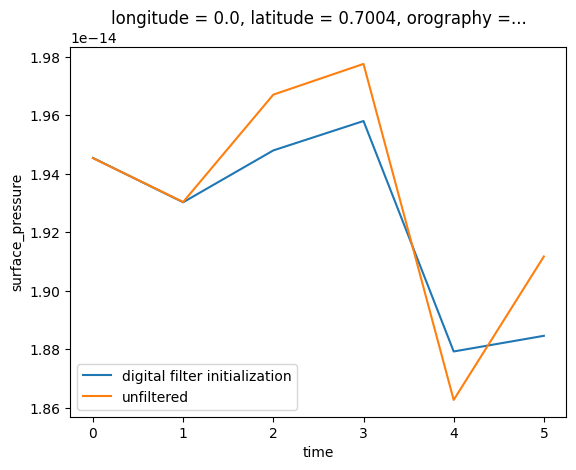

In [26]:
ds_out.surface_pressure.sel(latitude=0, longitude=0, method='nearest').plot.line(label='digital filter initialization');
ds_out_unfiltered.surface_pressure.sel(latitude=0, longitude=0, method='nearest').plot.line(label='unfiltered');
plt.legend()

##divergence

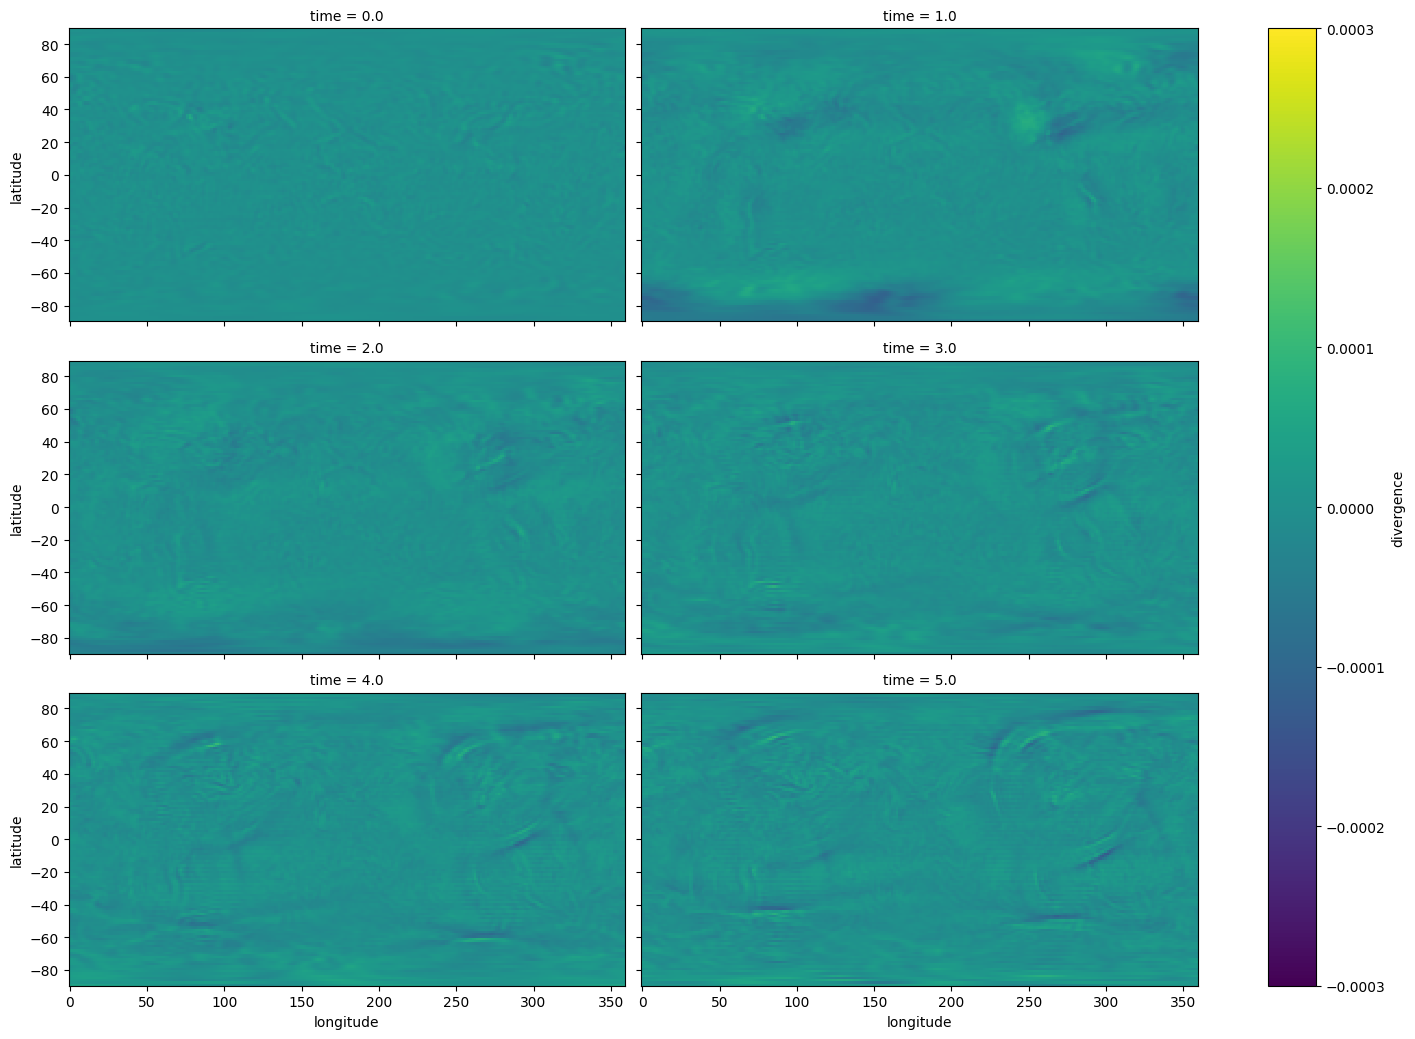

In [27]:
ds_out.divergence.isel(sigma=1).plot.imshow(
    col='time', x='longitude', y='latitude',
    col_wrap=2,
    aspect=2, size=3.5,
    cmap='viridis', vmin=-3e-4, vmax=3e-4,
)

##vorticity

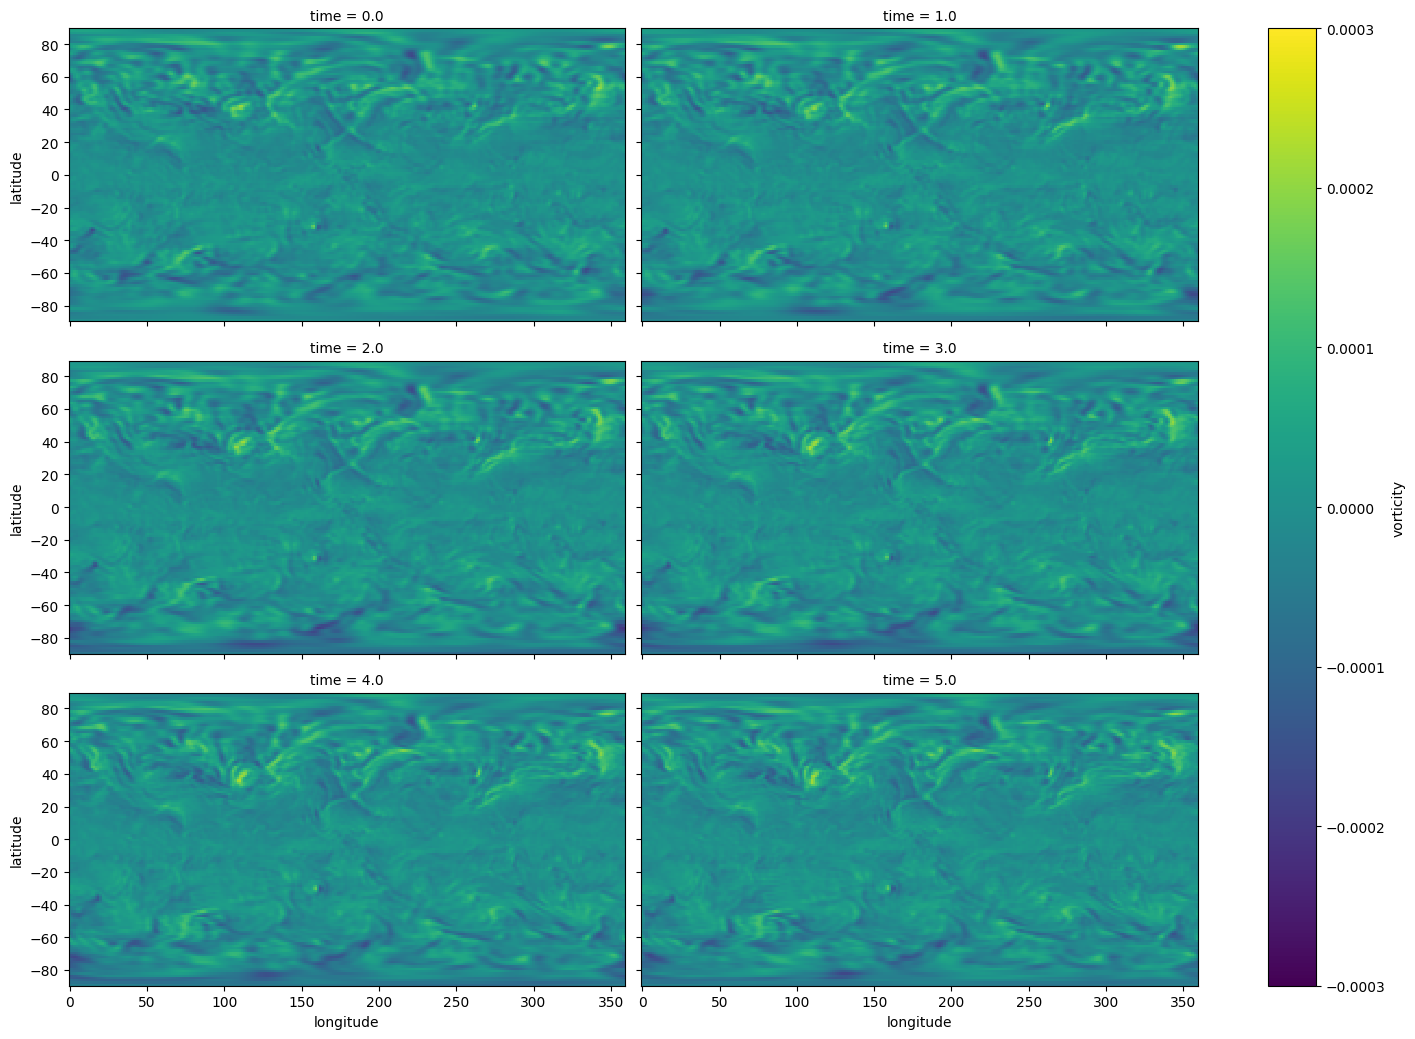

In [28]:
ds_out.vorticity.isel(sigma=1).plot.imshow(
    col='time', x='longitude', y='latitude',
    col_wrap=2,
    aspect=2, size=3.5,
    cmap='viridis', vmin=-3e-4, vmax=3e-4,
)

##temperature

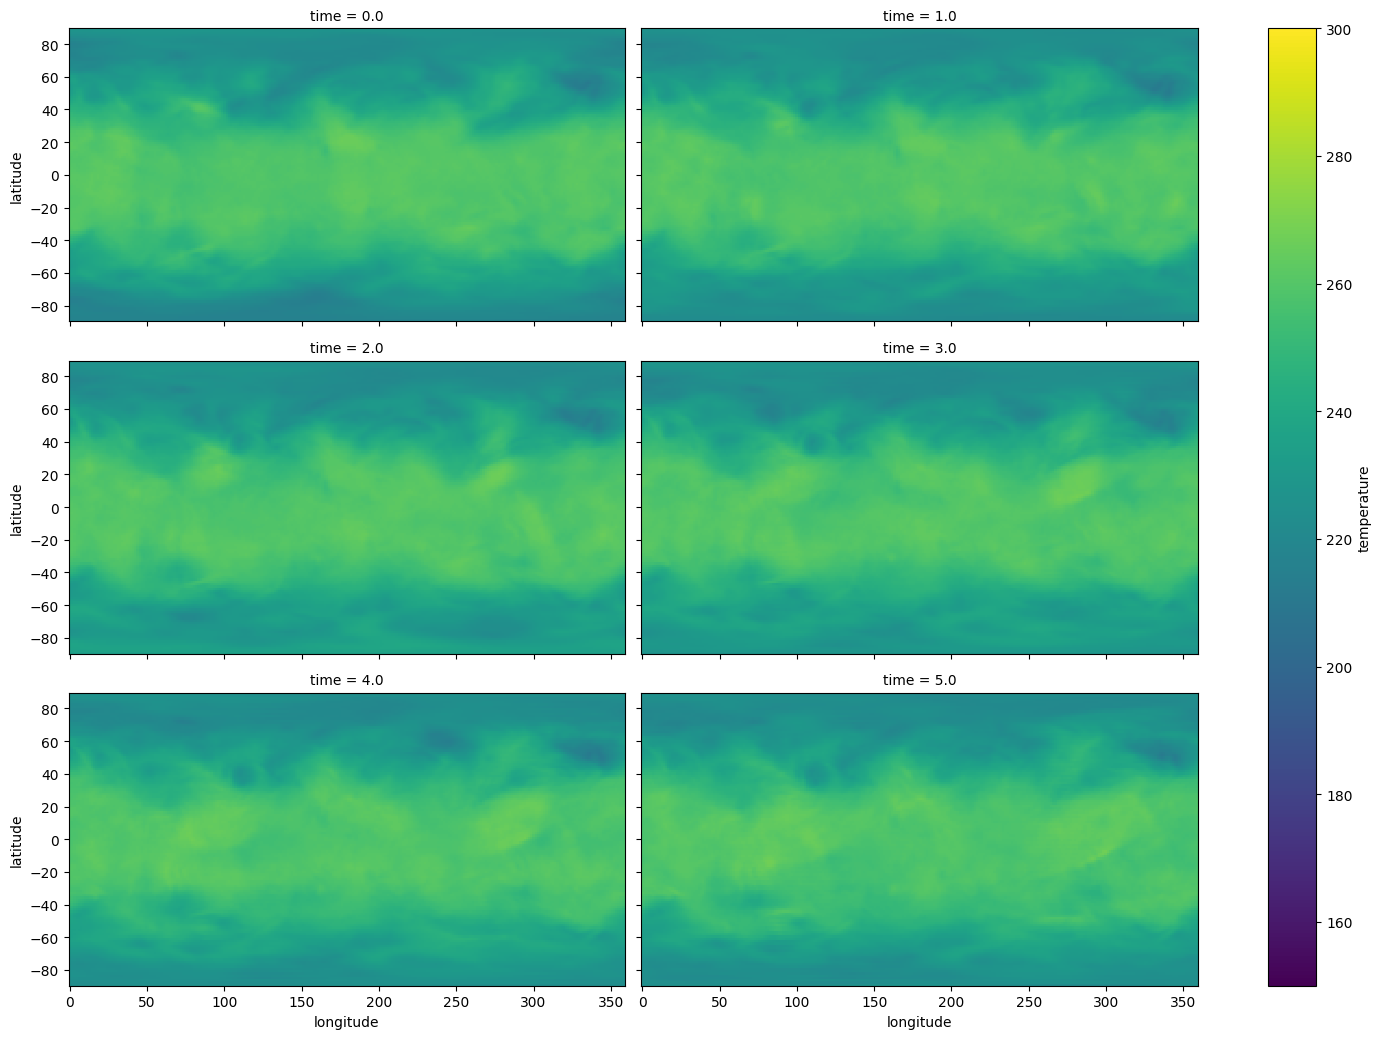

In [29]:
ds_out.temperature.isel(sigma=1).plot.imshow(
    col='time', x='longitude', y='latitude',
    col_wrap=2,
    aspect=2, size=3.5,
    cmap='viridis', vmin=150, vmax=300,
)

##specific_humidity

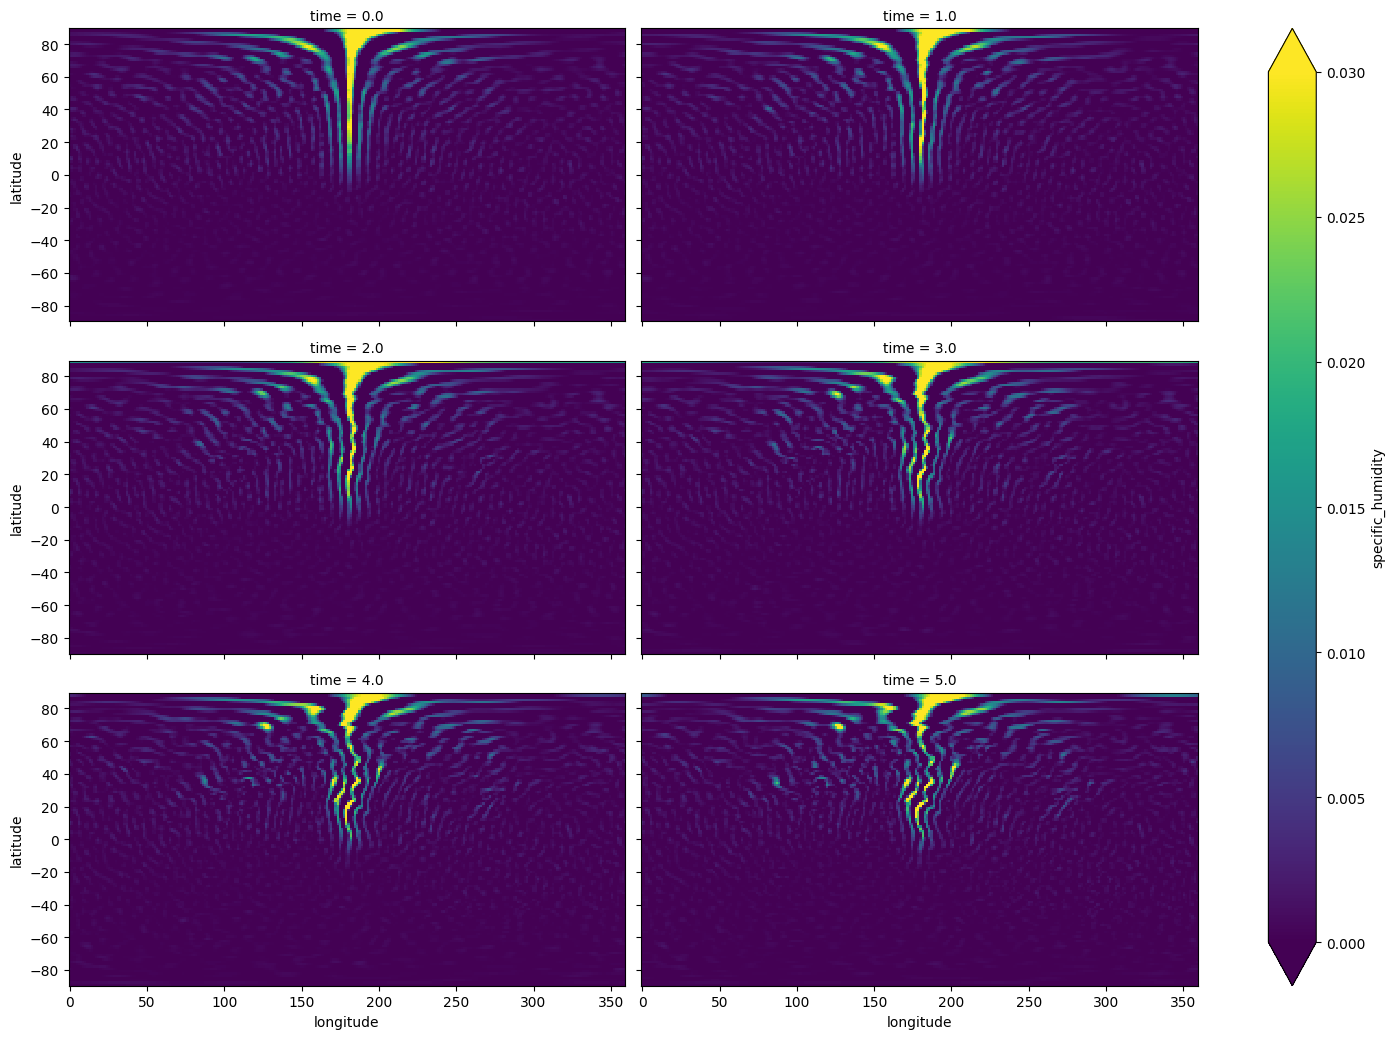

In [30]:
ds_out.specific_humidity.isel(sigma=1).plot.imshow(
    col='time', x='longitude', y='latitude',
    col_wrap=2,
    aspect=2, size=3.5,
    cmap='viridis', vmin=0, vmax=0.03,
)

##specific_cloud_water

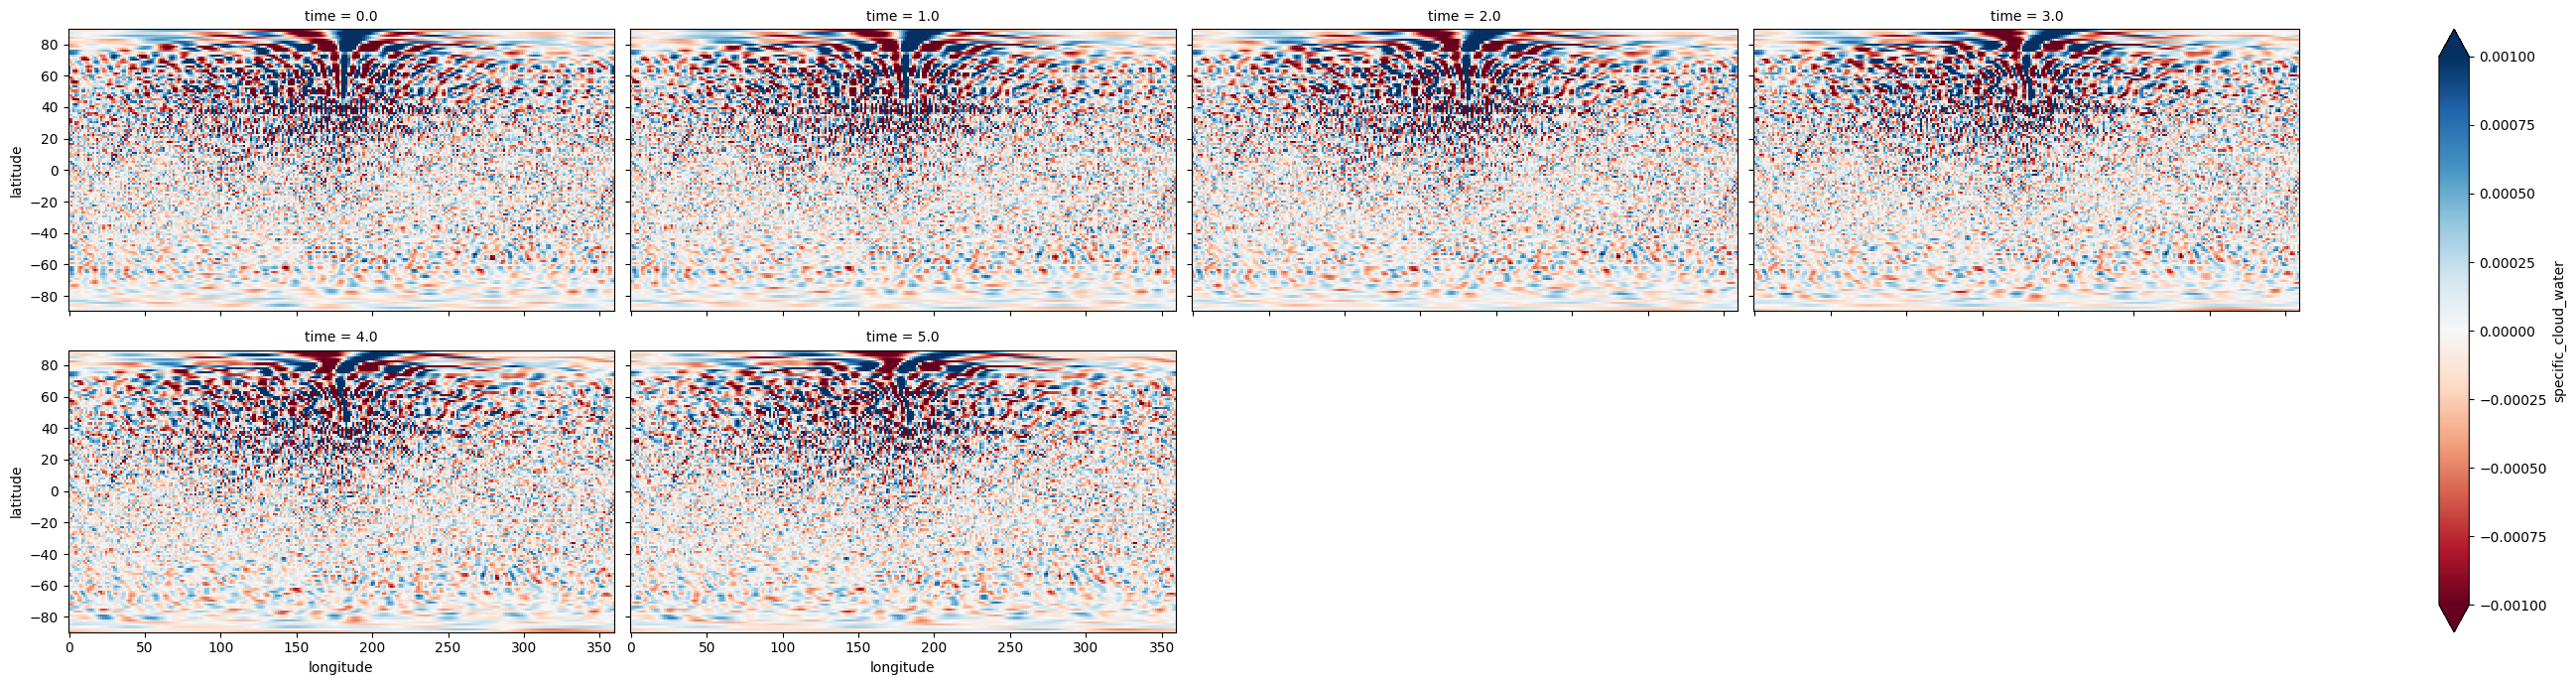

In [31]:
ds_out.specific_cloud_water.isel(sigma=2).plot.imshow(
    col='time', x='longitude', y='latitude',
    col_wrap=4,  # Nombre de colonnes pour l'affichage
    aspect=2, size=3.5,
    cmap='RdBu', vmin=-1e-3, vmax=1e-3,
)